# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [1]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from newsapi import NewsApiClient

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/folumccoy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!

Bad key savefig.frameon in file /opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /opt/anaconda3/envs/pyvizenv/lib/python3.7/site-pac

In [2]:
# Read your api key environment variable
load_dotenv()
api_key = os.getenv("NEWS_API_KEY")

In [3]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [4]:
# Fetch the Bitcoin news articles
bitcoin_news_en = newsapi.get_everything(
    q="bitcoin",
    language="en"
)

In [5]:
# Fetch the Ethereum news articles
ethereum_news_en = newsapi.get_everything(
    q="ethereum",
    language="en"
)

In [6]:
# Function to create a dataframe from news articles
def create_df(news):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

In [7]:
#Create the Bitcoin articles DataFrame
bitcoin_news_df = create_df(bitcoin_news_en['articles'])
#Create the Ethereum articles DataFrame
ethereum_news_df = create_df(ethereum_news_en['articles'])

#show dataframes
display(bitcoin_news_df.head(),ethereum_news_df.head())

,title,description,text,date
0,Miami’s Bitcoin Conference Left a Trail of Har...,"For some women, inappropriate conduct from oth...","Now, even though there are a number of women-f...",2022-05-10
1,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04
2,Warren Buffett Says He Wouldn't Take All the B...,Warren Buffett has always been a bitcoin skept...,Warren Buffett has always been a bitcoin skept...,2022-05-02
3,Luna Foundation Tried to Prop Up Terra’s Crumb...,"As a kid, I remember when my father tried to u...","As a kid, I remember when my father tried to u...",2022-05-16
4,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09


,title,description,text,date
0,Here's what NFTs look like on Instagram,Meta has revealed more of how NFTs will work o...,Meta has revealed more of how NFTs will work o...,2022-05-10
1,Yuga Labs apologises after sale of virtual lan...,Demand for plots of land in multiplayer game O...,A multi-billion dollar cryptocurrency company ...,2022-05-02
2,How Bored Ape Yacht Club Broke Ethereum - CNET,"Transactions stalled for hours, and people pai...",When Bored Ape Yacht Club creators Yuga Labs a...,2022-05-04
3,Cryptoverse: Ether prepares for epic 'merge' i...,Ether has promised to do better. It has promis...,April 26 (Reuters) - Ether has promised to do ...,2022-04-26
4,What is the Ethereum merge and how could it ma...,Ethereum is preparing for an upgrade that’s be...,Ethereum is preparing for an upgrade thats bee...,2022-04-26


In [8]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [9]:
# Sentiment to dataframe helper

def get_sentiment_df(df):
    title_sent = {
    "title_compound": [],
    "title_pos": [],
    "title_neu": [],
    "title_neg": [],
    "title_sent": [],
    }
    text_sent = {
        "text_compound": [],
        "text_pos": [],
        "text_neu": [],
        "text_neg": [],
        "text_sent": [],
    }

    # Get sentiment for the text and the title
    for index, row in df.iterrows():
        try:
            # Sentiment scoring with VADER
            title_sentiment = analyzer.polarity_scores(row["title"])
            title_sent["title_compound"].append(title_sentiment["compound"])
            title_sent["title_pos"].append(title_sentiment["pos"])
            title_sent["title_neu"].append(title_sentiment["neu"])
            title_sent["title_neg"].append(title_sentiment["neg"])
            title_sent["title_sent"].append(get_sentiment(title_sentiment["compound"]))

            text_sentiment = analyzer.polarity_scores(row["text"])
            text_sent["text_compound"].append(text_sentiment["compound"])
            text_sent["text_pos"].append(text_sentiment["pos"])
            text_sent["text_neu"].append(text_sentiment["neu"])
            text_sent["text_neg"].append(text_sentiment["neg"])
            text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
        except AttributeError:
            pass

    # Attaching sentiment columns to the News DataFrame
    title_sentiment_df = pd.DataFrame(title_sent)
    text_sentiment_df = pd.DataFrame(text_sent)
    df = df.join(title_sentiment_df).join(text_sentiment_df)

    return df.head()

In [10]:
# Create the Bitcoin sentiment scores DataFrame
bitcoin_sent_df = get_sentiment_df(bitcoin_news_df)

In [11]:
# Create the Ethereum sentiment scores DataFrame
ethereum_sent_df = get_sentiment_df(ethereum_news_df)

<AxesSubplot:title={'center':'Bitcoin News Title and Text Sentiment Comparison'}>

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-0.173500,0.051000,0.831800,0.117200,-0.20000,0.084100,0.072600,0.875800,0.051200,0.200000
std,0.418828,0.114039,0.163185,0.169018,0.83666,0.292187,0.029509,0.076074,0.058666,1.095445
min,-0.665200,0.000000,0.632000,0.000000,-1.00000,-0.326900,0.036000,0.772000,0.000000,-1.000000
25%,-0.542300,0.000000,0.745000,0.000000,-1.00000,-0.051600,0.056000,0.833000,0.000000,-1.000000
50%,0.000000,0.000000,0.782000,0.000000,0.00000,0.077200,0.072000,0.882000,0.052000,1.000000
75%,0.000000,0.000000,1.000000,0.218000,0.00000,0.340000,0.085000,0.928000,0.061000,1.000000
max,0.340000,0.255000,1.000000,0.368000,1.00000,0.381800,0.114000,0.964000,0.143000,1.000000


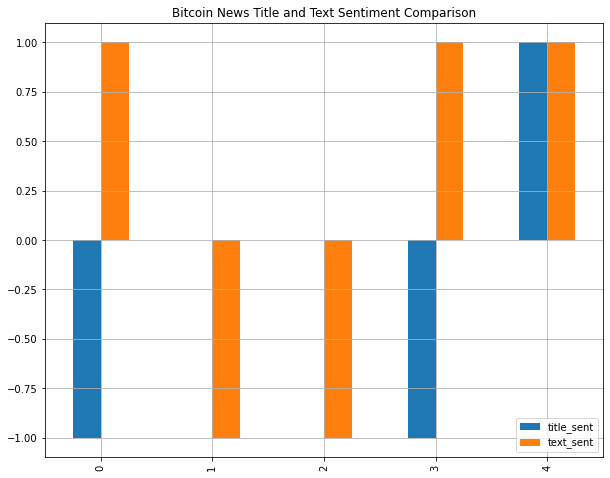

In [12]:
# Describe the Bitcoin Sentiment
display(bitcoin_sent_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="Bitcoin News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
),bitcoin_sent_df.describe())

<AxesSubplot:title={'center':'Ethereum News Title and Text Sentiment Comparison'}>

,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent
count,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-0.007180,0.092200,0.817800,0.090000,0.20000,0.191060,0.077600,0.896400,0.026000,0.200000
std,0.364147,0.133997,0.194191,0.201246,0.83666,0.425316,0.060459,0.040667,0.036297,1.095445
min,-0.599400,0.000000,0.550000,0.000000,-1.00000,-0.273200,0.000000,0.858000,0.000000,-1.000000
25%,0.000000,0.000000,0.706000,0.000000,0.00000,-0.226300,0.046000,0.865000,0.000000,-1.000000
50%,0.000000,0.000000,0.833000,0.000000,0.00000,0.271600,0.065000,0.879000,0.000000,1.000000
75%,0.202300,0.167000,1.000000,0.000000,1.00000,0.534600,0.135000,0.935000,0.055000,1.000000
max,0.361200,0.294000,1.000000,0.450000,1.00000,0.648600,0.142000,0.945000,0.075000,1.000000


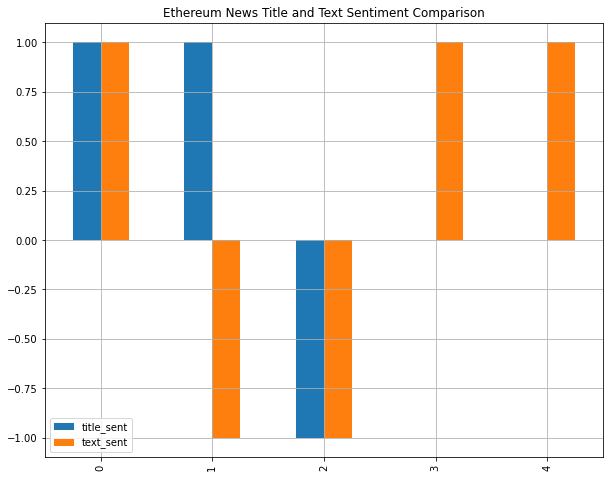

In [13]:
# Describe the Ethereum Sentiment
display(ethereum_sent_df.plot(
    y=["title_sent", "text_sent"],
    kind="bar",
    title="Ethereum News Title and Text Sentiment Comparison",
    figsize=(10, 8),
    grid=True,
),ethereum_sent_df.describe())

### Questions:

Q: Which coin had the highest mean positive score?

A: Ethereum with a scores of: title = 0.092200, text = 0.077600 was higher

Q: Which coin had the highest compound score?

A: Ethereum with a scores of: title = 0.361200, text = 0.648600 was higher

Q. Which coin had the highest positive score?

A: Ethereum with a scores of: title = 0.294000, text = 0.142000 was higher

---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [14]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [15]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))

# Expand the default stopwords list if necessary
sw_addon = {'crypto','cryptocurrency','cryptocurrencies','char','ha','reuters'}

In [16]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
   
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)    
    
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
   
    # Convert the words to lowercase and remove the stop words
    tokens = [word.lower() for word in lem if word.lower() not in sw.union(sw_addon)]
    
    return tokens

In [17]:
#Helper to convert dataframe to bigstring
def to_bigString(df,content):
    big_string = ''
    for index in df.iterrows():
        try:
            big_string = ' '.join(df[content])
        except AttributeError:
                pass
    return big_string

In [18]:
# Create a new tokens column for Bitcoin
btc_tkn = tokenizer(to_bigString(bitcoin_news_df,'text'))

In [19]:
# Create a new tokens column for Ethereum
eth_tkn = tokenizer(to_bigString(ethereum_news_df,'text'))

---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [20]:
from collections import Counter
from nltk import ngrams

In [21]:
#bigrams helper
def make_bigram(processed,number):
    bigram_counts = Counter(ngrams(processed, n=number))
    return dict(bigram_counts)

In [22]:
# Generate the Bitcoin N-grams where N=2
btc_ng2 = make_bigram(btc_tkn,2)

In [23]:
# Generate the Ethereum N-grams where N=2
eth_ng2 = make_bigram(eth_tkn,2)

In [24]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [25]:
# Use token_count to get the top 10 words for Bitcoin
token_count(btc_tkn)

[('bitcoin', 12), ('world', 6), ('week', 5)]

In [26]:
# Use token_count to get the top 10 words for Ethereum
token_count(eth_tkn)

[('bitcoin', 7), ('world', 6), ('ethereum', 5)]

---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

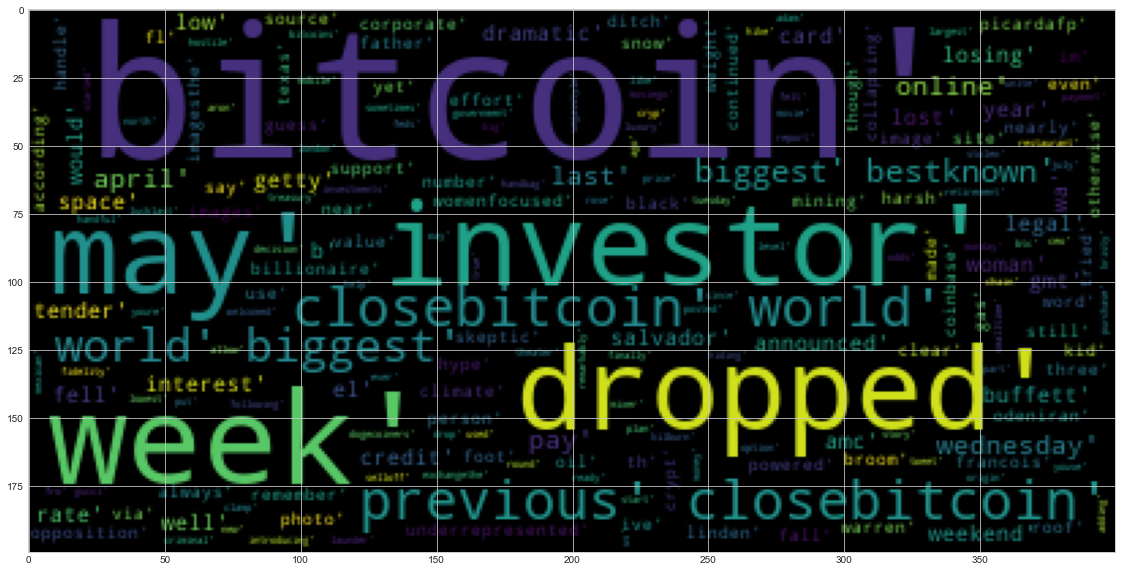

In [28]:
# Generate the Bitcoin word cloud
btc_wc = WordCloud().generate(str(btc_tkn))
plt.imshow(btc_wc)

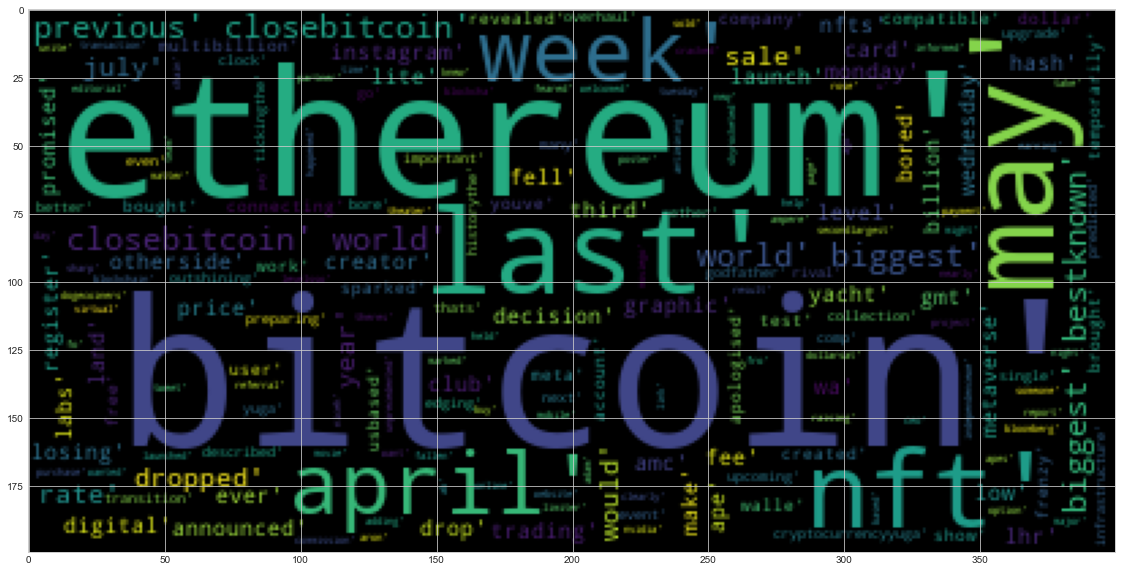

In [29]:
# Generate the Ethereum word cloud
eth_wc = WordCloud().generate(str(eth_tkn))
plt.imshow(eth_wc)

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [30]:
import spacy
from spacy import displacy

In [31]:
# Download the language model for SpaCy
# !python -m spacy download en_core_web_sm

In [32]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### Bitcoin NER

In [33]:
# Concatenate all of the Bitcoin text together
btc_str = to_bigString(bitcoin_news_df,'text')

In [34]:
# Run the NER processor on all of the text
btc_doc = nlp(btc_str)


# Add a title to the document
btc_doc.user_data["title"] = "Bitcoin NER"

In [35]:
# Render the visualization
displacy.render(btc_doc, style="ent")

In [36]:
# List all Entities
for ent in btc_doc.ents:
    print(ent.text,  ent.label_)

Odeniran GPE
Linden GPE
Texas GPE
April 4th, 2022 DATE
Photo PERSON
FRANCOIS PICARD/AFP ORG
Getty Images ORG
Warren Buffett PERSON
the weekend DATE
nearly three feet QUANTITY
Getty Images
 ORG
the weekend DATE
34,000 MONEY
27,630 MONEY
Coinbase PERSON
+2164 NORP
Last week DATE
Fidelity Investments ORG
the US Treasury ORG
last July DATE
33,000 MONEY
the week DATE
last week DATE
Fed ORG
Bitcoin ORG
Gucci handbag PERSON
week DATE
Kristy Kilburn PERSON
May 11 DATE
Reuters ORG
7.23% PERCENT
28,758.29 MONEY
GMT WORK_OF_ART
Wednesday DATE
2,241.68 MONEY
40.4% PERCENT
May 4 DATE
Reuters ORG
5.7% PERCENT
39,862.84 MONEY
Wednesday DATE
2,102.94 MONEY
20.9% PERCENT
year DATE
April 26 DATE
Reuters ORG
5.1% PERCENT
38,391.36 MONEY
Tuesday DATE
2,229.82 MONEY
16% PERCENT
year DATE
May 9 DATE
Reuters ORG
7.81% PERCENT
31,333.41 MONEY
GMT WORK_OF_ART
Monday DATE
2,655.98 MONEY
35% PERCENT
AMC ORG
April 15 DATE
AMC ORG
Adam Aron PERSON
Mexican NORP
North London LOC
a few weeks ago DATE
+2779 PERSON
May

---

### Ethereum NER

In [37]:
# Concatenate all of the Ethereum text together
eth_str = to_bigString(ethereum_news_df,'text')

In [38]:
# Run the NER processor on all of the text
eth_doc = nlp(eth_str)


# Add a title to the document
btc_doc.user_data["title"] = "Ethereum NER"

In [39]:
# Render the visualization
displacy.render(eth_doc, style="ent")

In [40]:
# List all Entities
for ent in eth_doc.ents:
    print(ent.text,  ent.label_)

Meta ORG
Instagram ORG
US GPE
Instagram ORG
Ethereum ORG
Yuga Labs PERSON
Yacht Club ORG
Yuga Labs PERSON
Otherside NFT LAW
April 30 DATE
NFT ORG
+6669 ORDINAL
April 26 DATE
Reuters ORG
No.2 CARDINAL
second ORDINAL
AMC ORG
April 15 DATE
AMC ORG
Adam Aron PERSON
Last night TIME
Bloomberg GPE
nearly a third CARDINAL
a billion dollars MONEY
47,454 MONEY
34,007 MONEY
28%.About a third CARDINAL
this week DATE
Nvidia PERSON
Ampere Lite Hash Rate WORK_OF_ART
LHR ORG
Ethereum ORG
May 4 DATE
Reuters ORG
5.7% PERCENT
39,862.84 MONEY
Wednesday DATE
2,102.94 MONEY
20.9% PERCENT
year DATE
April 26 DATE
Reuters ORG
5.1% PERCENT
38,391.36 MONEY
Tuesday DATE
2,229.82 MONEY
16% PERCENT
year DATE
May 11 DATE
Reuters ORG
7.23% PERCENT
28,758.29 MONEY
GMT WORK_OF_ART
Wednesday DATE
2,241.68 MONEY
40.4% PERCENT
May 9 DATE
Reuters ORG
7.81% PERCENT
31,333.41 MONEY
GMT WORK_OF_ART
Monday DATE
2,655.98 MONEY
35% PERCENT
NFT ORG
Ethereum ORG
Last week DATE
9 CARDINAL
8 CARDINAL
Nvidia ORG
LHR ORG
last year  DA

---